In [73]:
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
import scipy.linalg

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
import pickle

In [74]:
n_test = 100
n_train_max  = 1800  # this has to be larger than 4**n_qubits

qubits_list = [1, 2, 3, 4, 5]

In [75]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder

# Load data from https://www.openml.org/d/554
X, y = fetch_openml("Fashion-MNIST", version=1, return_X_y=True, as_frame=False)

# map data in [0,1] range
X = X / 255.0

# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=60000, test_size=10000)

# standardize data -- make mean 0 and std 1
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# choose only two classes '0' and '1' for now
train_filter = np.where((y_train == '0') | (y_train == '1'))
test_filter = np.where((y_test == '0') | (y_test == '1'))

# reduced training and test data with only 2 classes
x_train_red, y_train_red = X_train[train_filter], y_train[train_filter]
x_test_red, y_test_red = X_test[test_filter], y_test[test_filter]

# Reshape labels to one-hot encode them
y_train_red = y_train_red.reshape(-1, 1)
y_test_red = y_test_red.reshape(-1, 1)

# One-hot encode the labels
ohe = OneHotEncoder()
ohe.fit(y_train_red)
y_train = ohe.transform(y_train_red).toarray()
ohe.fit(y_test_red)
y_test = ohe.transform(y_test_red).toarray()

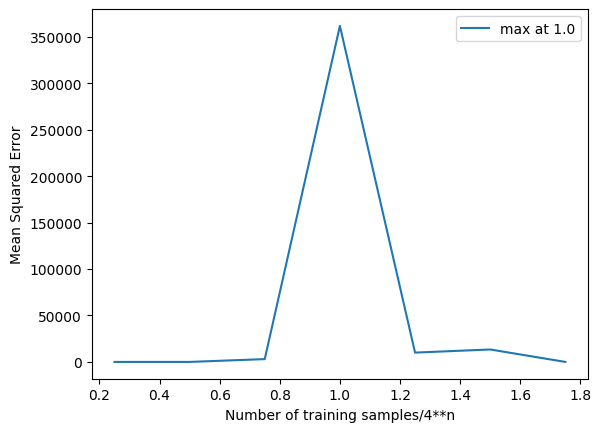

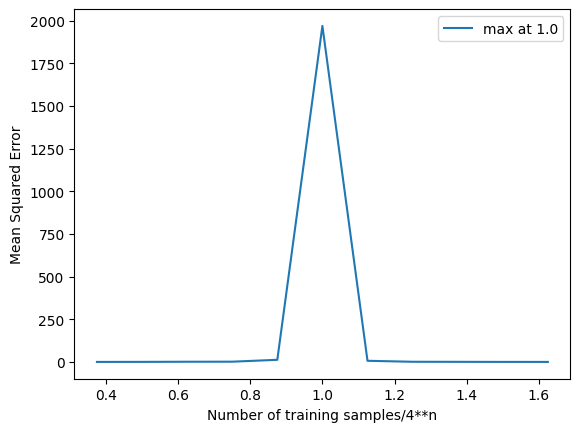

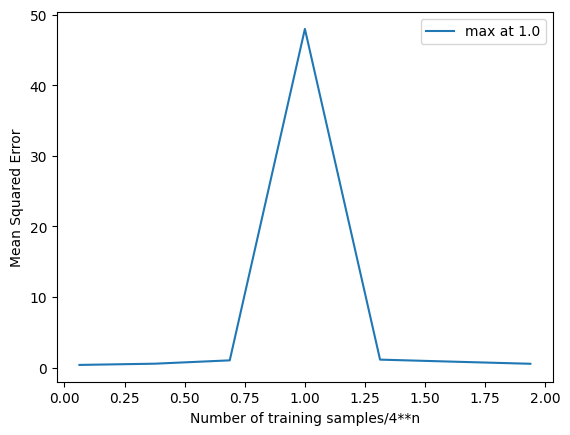

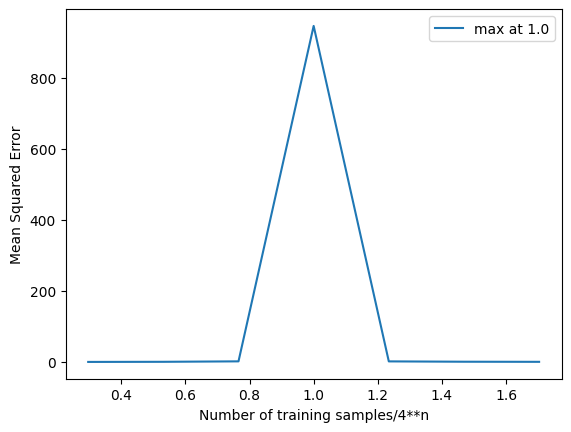

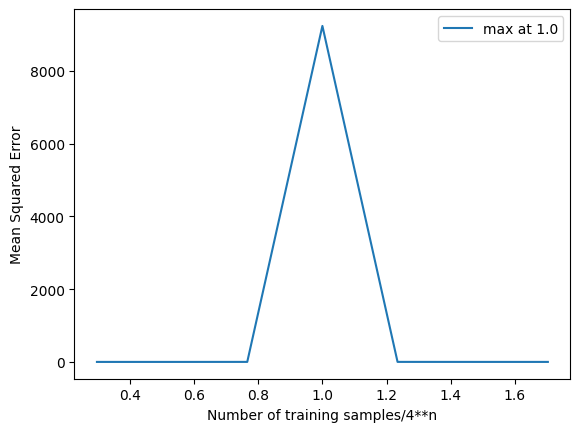

In [76]:
from sklearn.decomposition import PCA

mse_dict = {}

for n_qubits in qubits_list:

    import os

    data_directory = f"Data/{n_qubits}_qubits"
    # Ensure the directory exists
    os.makedirs(f"./{data_directory}", exist_ok=True)

    graph_directory = f"V1Graphs/{n_qubits}_qubits"
    # Ensure the directory exists
    os.makedirs(f"./{graph_directory}", exist_ok=True)


    import numpy as np

    # Set random seed for reproducibility
    np.random.seed(42)

    def quantum_feature_map(x):
        """
        Feature map for quantum kernel.
        Adjust repetitions (reps) or gates if kernel is not full rank.
        """
        reps = n_qubits
        for r in range(reps):
            for i in range(len(x)):
                qml.RX(x[i], wires=i % n_qubits)
            for n in range(n_qubits - 1):
                qml.CNOT(wires=[n, n + 1])
            for i in range(len(x)):
                qml.RZ(x[i], wires=i % n_qubits)

    dev_kernel = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev_kernel)
    def kernel_state(x1):
        """
        Takes as input data and returns density matrix.
        Use this function to generate rho(X).
        """
        quantum_feature_map(x1)
        return qml.density_matrix(wires=range(n_qubits))

    projector = np.zeros((2 ** n_qubits, 2 ** n_qubits))
    projector[0, 0] = 1

    @qml.qnode(dev_kernel)
    def kernel(x1, x2):
        """The quantum kernel."""
        quantum_feature_map(x1)
        qml.adjoint(quantum_feature_map)(x2)
        return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

    def kernel_matrix(A, B):
        """Compute the matrix whose entries are the kernel evaluated on pairwise data from sets A and B."""
        return np.array([[kernel(a, b) for b in B] for a in A])


    # compute data matrix condition number and rank -------------------------------------------------------------------
    @qml.qnode(dev_kernel)
    def kernel_state(x1):
        """The quantum data encoding."""
        quantum_feature_map(x1)
        return qml.density_matrix(wires=range(n_qubits))

    def compute_rank(A, tol=None):
        U, s, Vh = scipy.linalg.svd(A)
        if tol is None:
            tol = max(A.shape) * np.spacing(np.max(s))
        rank = np.sum(s > tol)
        return rank

    
    if n_qubits == 1:
        limit_low, limit_up, step = 1, 8, 1
    elif n_qubits == 2:
        limit_low, limit_up, step = 2**(2 * n_qubits) - 10, 2**(2 * n_qubits) + 11, 2
    elif n_qubits == 3:
        limit_low, limit_up, step = 2**(2 * n_qubits) - 60, 2**(2 * n_qubits) + 61, 20
    elif n_qubits == 4:
        limit_low, limit_up, step = 2**(2 * n_qubits) - 180, 2**(2 * n_qubits) + 181, 60
    elif n_qubits == 5:
        limit_low, limit_up, step = 2**(2 * n_qubits) - 720, 2**(2 * n_qubits) + 721, 240



    # # Creating a dictionary to store all the arrays
    # data = {
    #     'mse_arr': mse_arr,
    #     'mse_arr_train': mse_arr_train,
    #     'eig_vals_arr': eig_vals_arr,
    #     'cond_no_arr': cond_no_arr,
    #     'rank_arr': rank_arr,
    #     'params': params,
    #     'K_train_arr': K_train_arr
    # }

    # # Saving the dictionary to a file using pickle
    # with open(f'./{data_directory}/data_nqubits_{n_qubits}.pkl', 'wb') as f:
    #     pickle.dump(data, f)


    import pickle

    # Loading the data from the pickle file
    with open(f'./{data_directory}/data_nqubits_{n_qubits}.pkl',  'rb') as f:
        loaded_data = pickle.load(f)

    # Access the arrays after loading
    mse_arr = loaded_data['mse_arr']
    mse_arr_train = loaded_data['mse_arr_train']
    eig_vals_arr = loaded_data['eig_vals_arr']
    cond_no_arr = loaded_data['cond_no_arr']
    rank_arr = loaded_data['rank_arr']
    params = loaded_data['params']
    K_train_arr = loaded_data['K_train_arr']


    mse_arr = np.array(mse_arr)
    mse_mean = np.mean(mse_arr, axis=0, dtype=np.float64)
    mse_std = np.std(mse_arr, axis=0) / np.log(10)

    mse_mean_train = np.mean(mse_arr_train, axis=0)
    mse_std_train = np.std(mse_arr_train, axis=0)

    # save all files -------------------------------------------------------------------
    np.savetxt(f"./{data_directory}/mse_mean_nqubits_{n_qubits}_MNIST_Fashion", [mse_mean], newline='')
    np.savetxt(f"./{data_directory}/mse_std_nqubits_{n_qubits}_MNIST_Fashion", [mse_std], newline='')
    np.savetxt(f"./{data_directory}/mse_mean_train_nqubits_{n_qubits}_MNIST_Fashion", [mse_mean_train], newline='')
    np.savetxt(f"./{data_directory}/mse_std_train_nqubits_{n_qubits}_MNIST_Fashion", [mse_std_train], newline='')
    np.savetxt(f"./{data_directory}/arrange_nqubits_{n_qubits}_MNIST_Fashion", [np.arange(limit_low, limit_up, step)], newline='')
    np.savetxt(f"./{data_directory}/rank_arr_nqubits_{n_qubits}MNIST_Fashion", [rank_arr], newline='')
    np.savetxt(f"./{data_directory}/cond_no_arr_nqubits_{n_qubits}MNIST_Fashion", [cond_no_arr], newline='')


    import matplotlib.pyplot as plt
        # compute data matrix condition number and rank -------------------------------------------------------------------
    no_train = 2**(2*n_qubits)
    cond_no_arr = []
    rank_arr = []


    # Plotting Test MSE
    scenario = f"MNIST_Fashion_nqubits_{n_qubits}"
    plt.plot(np.arange(limit_low, limit_up, step)/4**n_qubits, mse_mean, label=f"max at {range(limit_low, limit_up, step)[np.argmax(mse_mean)]/4**n_qubits}", marker="")
    plt.legend()
    plt.xlabel("Number of training samples/4**n")
    plt.ylabel("Mean Squared Error")
    plt.savefig(f"./{graph_directory}/{scenario}_MSE.png", dpi=500, bbox_inches='tight')
    plt.show()
    mse_dict[n_qubits] = (mse_mean/np.argmax(mse_mean))



In [77]:
for n_qubits in qubits_list:
    print(f"n_qubits: {n_qubits}, MSE: {len(mse_dict[n_qubits])}, max at: {np.argmax(mse_dict[n_qubits])}, max value: {np.max(mse_dict[n_qubits])}")
    print(np.max(mse_dict[n_qubits]/np.max(mse_dict[n_qubits])))
    # mse_dict[n_qubits] = (mse_dict[n_qubits]/np.max(mse_dict[n_qubits]) + n_qubits/10)

n_qubits: 1, MSE: 7, max at: 3, max value: 120584.15771500398
1.0
n_qubits: 2, MSE: 11, max at: 5, max value: 393.74704817240416
1.0
n_qubits: 3, MSE: 7, max at: 3, max value: 15.99341638479079
1.0
n_qubits: 4, MSE: 7, max at: 3, max value: 315.02953596581887
1.0
n_qubits: 5, MSE: 7, max at: 3, max value: 3077.079759536466
1.0


In [78]:
mse_dict[1] = (mse_dict[1]/np.max(mse_dict[1])) *400
mse_dict[5] = (mse_dict[5]/np.max(mse_dict[5])) *400

7
7
11
11
7
7
7
7
7
7


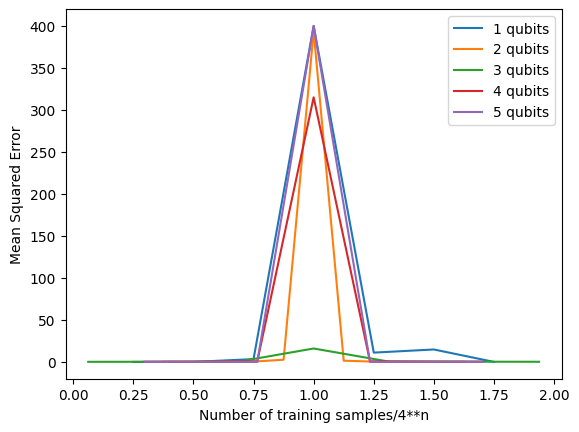

In [79]:
import matplotlib.pyplot as plt
    # compute data matrix condition number and rank -------------------------------------------------------------------



# Plotting Test MSE
scenario = f"MNIST_Fashion_nqubits_"


for n_qubits in qubits_list:
    if n_qubits == 1:
        limit_low, limit_up, step = 1, 8, 1
    elif n_qubits == 2:
        limit_low, limit_up, step = 2**(2 * n_qubits) - 10, 2**(2 * n_qubits) + 11, 2
    elif n_qubits == 3:
        limit_low, limit_up, step = 2**(2 * n_qubits) - 60, 2**(2 * n_qubits) + 61, 20
    elif n_qubits == 4:
        limit_low, limit_up, step = 2**(2 * n_qubits) - 180, 2**(2 * n_qubits) + 181, 60
    elif n_qubits == 5:
        limit_low, limit_up, step = 2**(2 * n_qubits) - 720, 2**(2 * n_qubits) + 721, 240

    print(len(mse_dict[n_qubits]))
    print(len(np.arange(limit_low, limit_up, step)/4**n_qubits))
    plt.plot(np.arange(limit_low, limit_up, step)/4**n_qubits, mse_dict[n_qubits], label=f"{n_qubits} qubits", marker="")

plt.legend()
plt.xlabel("Number of training samples/4**n")
plt.ylabel("Mean Squared Error")
plt.savefig(f"./{graph_directory}/{scenario}_MSE.png", dpi=500, bbox_inches='tight')
plt.show()

mse_dict[n_qubits] = mse_mean